In [1]:
#import proglearn
#from proglearn.forest import UncertaintyForest
import hyppo
import numpy as np
from numba import njit
from hyppo.independence.base import IndependenceTest
from hyppo._utils import perm_test
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import copy 
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal
from scipy.integrate import nquad

C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
import sys
sys.executable
sys.path
sys.path.append('C:\\Users\\siptest\\AppData\\Roaming\\Python\\Python36\\Scripts')

In [ ]:
def uf(X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
    
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(), 
                              n_estimators=n_estimators, 
                              max_samples=max_samples, 
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)
    
    cond_entropy = 0
    for tree_idx, tree in enumerate(model):
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
        
        # Randomly split the rest into voting and evaluation.
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        vote_indices = unsampled_indices[:total_unsampled//2]
        eval_indices = unsampled_indices[total_unsampled//2:]
        
        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        est_nodes = tree.apply(X[vote_indices])
        est_classes = y[vote_indices]
        for i in range(len(est_nodes)):
            class_counts[est_nodes[i], est_classes[i]] += 1
        
        row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
        row_sums[row_sums == 0] = 1 # Avoid divide by zero.
        class_probs = class_counts / row_sums[:, None]
        
        # Make the nodes that have no estimation indices uniform.
        # This includes non-leaf nodes, but that will not affect the estimate.
        class_probs[np.argwhere(class_probs.sum(axis = 1) == 0)] = [1 / K]*K
        
        # Apply finite sample correction and renormalize.
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
        row_sums = class_probs.sum(axis=1)
        class_probs = class_probs / row_sums[:, None]
        
        # Place evaluation points in their corresponding leaf node.
        # Store evaluation posterior in a num_eval-by-num_class matrix.
        eval_class_probs = class_probs[tree.apply(X[eval_indices])]
        # eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
        cond_entropy += np.mean(eval_entropies)

      
    return cond_entropy / n_estimators
        

In [ ]:
#n = 20 used for csv 1, 2
n = 50 
#n = 6000
mus = range(5)
ds = range(1, 16)
mu = 1
num_trials = 10
#reps = 1
d = 2
pis = [0.05 * i for i in range(1, 20)]

In [ ]:
def _perm_stat(X, y, is_distsim = True, permuter = None): 
    if permuter is None: 
        order = np.random.permutation(y.shape[0])
    else: 
        order = permuter()
    
    if is_distsim: 
        permy = y[order][:, order]
    else: 
        permy = y[order]
    
    #perm_stat = uf(X, permy, n, d, pis, num_trials)
    perm_stat = uf(X, permy)
    
    return perm_stat

In [ ]:
def perm_test(X, y, workers = -1, is_distsim=True, perm_block = None, reps = 100): 

    # calculate observed test statistic
    #stat = uf(X, y, n, d, pis, num_trials)
    stat = uf(X, y)
    #print(stat) 

    # calculate null distribution
    null_dist = np.array(
        Parallel(n_jobs=-2)(
            [
                delayed(_perm_stat)(X, y, False) 
                for rep in range(reps)
            ]
        )
    )
            
    pvalue = (null_dist >= stat).sum() / reps

    # correct for a p-value of 0. This is because, with bootstrapping
    # permutations, a p-value of 0 is incorrect
    if pvalue == 0:
        pvalue = 1 / reps

    #return stat, pvalue, null_dist
    print(stat, pvalue, null_dist)
    return pvalue

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF
from hyppo.sims import *
from hyppo.ksample._utils import k_sample_transform
pvalues = []
for i in range(1, 100): 
    matrix1, matrix2 = hyppo.sims.trans_2samp(multimodal_independence, 100, 1, noise=True, degree=90, trans=0.3)
    x, y = k_sample_transform([matrix1, matrix2])
    pval = perm_test(x, y)
    pvalues.append(pval)
#np.savetxt('C:/Users/siptest/Desktop/NDD/IndependencePvalsPermTestChangeAll2.csv',
               #pvalues, delimiter=',')    
np.savetxt('C:/Users/siptest/Desktop/NDD/IndependenceMultiModal_100Reps.csv',
               pvalues, delimiter=',') 
ecdf = ECDF(pvalues) 
plt.plot(ecdf.x, ecdf.y)
plt.show()

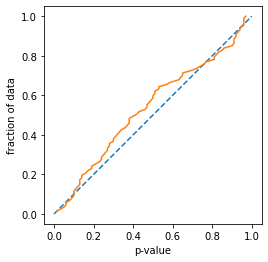

In [3]:
from statsmodels.distributions.empirical_distribution import ECDF
#toPlot = np.genfromtxt('C:/Users/siptest/Desktop/NDD/IndependencePvalsPermTestChangeAll.csv', delimiter=',')
#toPlot = [0.909, 0.431, 0.519, 0.877, 0.891, 0.072, 0.292, 0.587, 0.426, 0.952, 0.281, 0.647, 0.785, 0.185, 0.587, 0.445, 0.37, 0.35, 0.689, 0.66, 0.474, 0.602]
toPlot = np.genfromtxt('C:/Users/siptest/Desktop/NDD/Multimodal100Reps.csv', delimiter=',') 
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = 1 * x_vals
plt.plot(x_vals, y_vals, '--')
ecdf = ECDF(toPlot)
plt.plot(ecdf.x, ecdf.y)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("p-value")
plt.ylabel("fraction of data")
plt.savefig('C:/Users/siptest/Desktop/NDD/IndependenceMultimodalPvalsCorrectUF.png')
plt.show()